In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [3]:
from matplotlib.colors import ListedColormap ## used to create custom colormaps
import matplotlib.patches as patches ## patches is used to plot rectangles

In [4]:
vwind_path = "../DATASORT/VWIND/DATA/"

In [5]:
vwind5 = xr.open_dataset(vwind_path+"cmip5vwindmapdata.nc")
vwind5.load() ## .load() was required in order to use xr.corr()
vwind6 = xr.open_dataset(vwind_path+"cmip6vwindmapdata.nc")
vwind6.load()

<xarray.Dataset>
Dimensions:          (Model: 38, lat: 181, lon: 360)
Coordinates:
  * Model            (Model) object 'ACCESS-CM2' ... 'UKESM1-0-LL'
  * lat              (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
  * lon              (lon) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
Data variables:
    vpast_em         (Model, lat, lon) float64 0.1163 0.1418 ... 1.868 1.868
    vfut_em          (Model, lat, lon) float64 -0.6305 -0.5813 ... 1.985 1.985
    vpast_em_k4to32  (Model, lat, lon) float64 -0.2545 -0.2093 ... 9.723e-18
    vfut_em_k4to32   (Model, lat, lon) float64 -0.6413 -0.8227 ... 0.0 0.0

In [6]:
v_ind5 = xr.open_dataset(vwind_path+"cmip5vwindindices.nc")
v_ind5.load()
v_ind6 = xr.open_dataset(vwind_path+"cmip6vwindindices.nc")
v_ind6.load()

<xarray.Dataset>
Dimensions:        (Model: 38)
Coordinates:
  * Model          (Model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
Data variables:
    vpastsw_em     (Model) float64 2.913 4.391 3.179 4.122 ... 2.42 2.563 3.854
    vfutsw_em      (Model) float64 1.16 2.205 1.831 1.03 ... 1.572 1.533 1.911
    vpastsw_1mem   (Model) float64 2.986 3.974 4.279 4.382 ... 2.137 2.563 3.834
    vfutsw_1mem    (Model) float64 1.16 2.089 1.831 1.03 ... 1.572 1.533 1.759
    vpastamp_em    (Model) float64 2.591 2.328 2.107 3.092 ... 2.637 2.855 1.786
    vpastamp_1mem  (Model) float64 2.479 2.113 2.275 3.108 ... 2.711 2.855 1.597

In [7]:
lats = np.arange(0, 90, 1)

In [8]:
vwind6 = vwind6.sel(lat = lats)
vwind5 = vwind5.sel(lat = lats)

#### set up figure formatting:

In [9]:
titlesize = 10
datacrs = ccrs.PlateCarree()

create custom colormaps: 

In [10]:
def combine_cmaps(n, white = 2, neg = "Blues", pos = "YlOrRd"):
    """ combine two existing cmaps to create a diverging cmap with white in the middle
    n = number of colors on each side
    white = number of white spots
    neg = name of cmap for negative side
    pos = name of cmap for positive side"""
    
    new_col = ListedColormap(np.concatenate(
    [plt.cm.get_cmap(neg)(np.flip(np.linspace(start = 0.1, stop = 1, num = n))), 
    np.ones((white, 4)), 
    plt.cm.get_cmap(pos)(np.linspace(start = 0.1, stop = 1, num = n))]))
    
    return new_col

In [11]:
vwind_col = combine_cmaps(5)
vwind_breaks = np.arange(-12, 14, 2)
vwind_contours = np.concatenate([np.arange(-12, 0, 2), np.arange(2, 14, 2)])

vdiff_col = combine_cmaps(9)
vdiff_breaks = np.arange(-4, 4.5, 0.5)
vdiff_contours = np.concatenate([np.arange(-4, 0, 0.5), np.arange(0.5, 4.5, 0.5)])

var_col = combine_cmaps(9)
var_breaks = np.arange(-10, 11, 1)
var_contours = np.concatenate([np.arange(-10, 0, 1), np.arange(1, 11, 1)])

cor_col = combine_cmaps(4)
cor_breaks = np.arange(-1, 1.2, 0.2)
cor_contours = np.concatenate([np.arange(-1, 0, 0.2), np.arange(0.2, 1.2, 0.2)])

In [12]:
def format_map(ax):
    ax.set_aspect('auto')
    ax.set_ylim(0,90)
    ax.add_feature(cfeature.COASTLINE)

    ax.set_xticks([0, 90, 180, 270, 360], crs=ccrs.PlateCarree())
    ax.set_yticks([0, 30, 60, 90], crs=ccrs.PlateCarree())
    
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True, 
                                                   degree_symbol=''))
    ax.yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=''))

### Figure 6

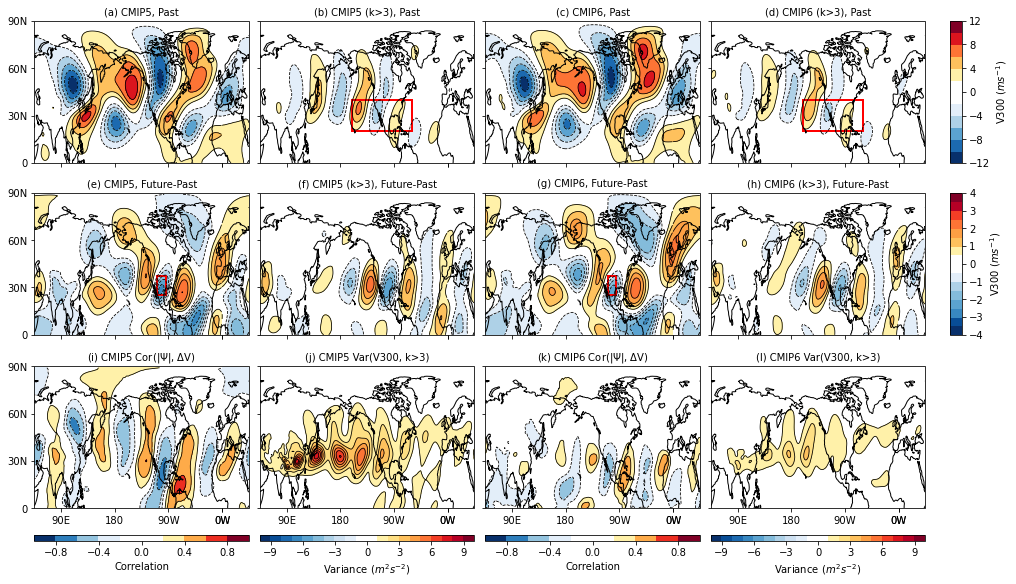

In [13]:
## create overall figure and sub-plots ("axes"). sharex and sharey mean share axis tick labels. 
## constrained_layout makes maps the same dimensions even when there are colorbars added
## I'm still learning the best way to create multi-panel figures, but this seems to work pretty well
fig, axes = plt.subplots(nrows = 3, ncols = 4, sharex = True, sharey = True, figsize = (14, 8), 
                         constrained_layout = True, 
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude = -135)})

## a
ax = axes[0,0]
ax.set_title('(a) CMIP5, Past', size = titlesize)
cf = ax.contourf(vwind5['vpast_em'].mean(dim = "Model"), 
            cmap = vwind_col, levels = vwind_breaks, transform = datacrs) ## filled contours
ax.contour(vwind5['vpast_em'].mean(dim = "Model"),
           levels = vwind_contours, transform = datacrs, colors = 'k', linewidths = 0.8) ## contour lines
format_map(ax)

## b
ax = axes[0,1]
ax.set_title('(b) CMIP5 (k>3), Past', size = titlesize)
cf = ax.contourf(vwind5['vpast_em_k4to32'].mean(dim = "Model"), 
            cmap = vwind_col, levels = vwind_breaks, transform = datacrs)
ax.contour(vwind5['vpast_em_k4to32'].mean(dim = "Model"),
           levels = vwind_contours, transform = datacrs, colors = 'k', linewidths = 0.8)
ax.add_patch(patches.Rectangle(xy=[-160, 20], width=100, height=20, facecolor='none', linewidth = 2, edgecolor = 'r',
                            transform=ccrs.PlateCarree()))
format_map(ax)

## c
ax = axes[0,2]
ax.set_title('(c) CMIP6, Past', size = titlesize)
cf = ax.contourf(vwind6['vpast_em'].mean(dim = "Model"), 
            cmap = vwind_col, levels = vwind_breaks, transform = datacrs)
ax.contour(vwind6['vpast_em'].mean(dim = "Model"),
           levels = vwind_contours, transform = datacrs, colors = 'k', linewidths = 0.8)
format_map(ax)

## d
ax = axes[0,3]
ax.set_title('(d) CMIP6 (k>3), Past', size = titlesize)
cf = ax.contourf(vwind6['vpast_em_k4to32'].mean(dim = "Model"), 
            cmap = vwind_col, levels = vwind_breaks, transform = datacrs)
ax.contour(vwind6['vpast_em_k4to32'].mean(dim = "Model"),
           levels = vwind_contours, transform = datacrs, colors = 'k', linewidths = 0.8)
ax.add_patch(patches.Rectangle(xy=[-160, 20], width=100, height=20, facecolor='none', linewidth = 2, edgecolor = 'r',
                            transform=ccrs.PlateCarree()))
format_map(ax)
fig.colorbar(cf, ax = axes[0,], label = "V300 ($ms^{-1}$)") ## add shared colorbar for the top row, by default it's on the right

## e
ax = axes[1,0]
ax.set_title('(e) CMIP5, Future-Past', size = titlesize)
cf = ax.contourf((vwind5['vfut_em'] - vwind5['vpast_em']).mean(dim = "Model"), 
            cmap = vdiff_col, levels = vdiff_breaks, transform = datacrs)
ax.contour((vwind5['vfut_em'] - vwind5['vpast_em']).mean(dim = "Model"),
           levels = vdiff_contours, transform = datacrs, colors = 'k', linewidths = 0.8)
ax.add_patch(patches.Rectangle((-110, 25),width = 15, height = 12,facecolor='none', linewidth = 2, edgecolor = 'r',
                            transform=ccrs.PlateCarree()))
format_map(ax)

## f
ax = axes[1,1]
ax.set_title('(f) CMIP5 (k>3), Future-Past', size = titlesize)
cf = ax.contourf((vwind5['vfut_em_k4to32'] - vwind5['vpast_em_k4to32']).mean(dim = "Model"), 
            cmap = vdiff_col, levels = vdiff_breaks, transform = datacrs)
ax.contour((vwind5['vfut_em_k4to32'] - vwind5['vpast_em_k4to32']).mean(dim = "Model"),
           levels = vdiff_contours, transform = datacrs, colors = 'k', linewidths = 0.8)
format_map(ax)

## g
ax = axes[1,2]
ax.set_title('(g) CMIP6, Future-Past', size = titlesize)
cf = ax.contourf((vwind6['vfut_em'] - vwind6['vpast_em']).mean(dim = "Model"), 
            cmap = vdiff_col, levels = vdiff_breaks, transform = datacrs)
ax.contour((vwind6['vfut_em'] - vwind6['vpast_em']).mean(dim = "Model"),
           levels = vdiff_contours, transform = datacrs, colors = 'k', linewidths = 0.8)
ax.add_patch(patches.Rectangle((-110, 25),width = 15, height = 12, facecolor='none', linewidth = 2, edgecolor = 'r',
                            transform=ccrs.PlateCarree()))
format_map(ax)

## h
ax = axes[1,3]
ax.set_title('(h) CMIP6 (k>3), Future-Past', size = titlesize)
cf = ax.contourf((vwind6['vfut_em_k4to32'] - vwind6['vpast_em_k4to32']).mean(dim = "Model"), 
            cmap = vdiff_col, levels = vdiff_breaks, transform = datacrs)
ax.contour((vwind6['vfut_em_k4to32'] - vwind6['vpast_em_k4to32']).mean(dim = "Model"),
           levels = vdiff_contours, transform = datacrs, colors = 'k', linewidths = 0.8)
format_map(ax)
fig.colorbar(cf, ax = axes[1,], label = "V300 ($ms^{-1}$)")

## i
ax = axes[2,0]
ax.set_title('(i) CMIP5 Cor(|$\Psi$|, $\Delta$V)', size = titlesize)
cf = ax.contourf(xr.corr(v_ind5["vpastamp_em"], (vwind5['vfut_em'] - vwind5['vpast_em']), dim = "Model"), 
           cmap = cor_col, levels = cor_breaks, transform = datacrs)
ax.contour(xr.corr(v_ind5["vpastamp_em"], (vwind5['vfut_em'] - vwind5['vpast_em']), dim = "Model"), 
          transform = datacrs, levels = cor_contours, colors = "k", linewidths = 0.8)
format_map(ax)
fig.colorbar(cf, location = 'bottom', ax = axes[2,0], label = "Correlation")

## j
ax = axes[2,1]
ax.set_title('(j) CMIP5 Var(V300, k>3)', size = titlesize)
cf = ax.contourf(vwind5['vpast_em_k4to32'].var(dim = "Model"), 
            cmap = var_col, levels = var_breaks, transform = datacrs)
ax.contour(vwind5['vpast_em_k4to32'].var(dim = "Model"),
           transform = datacrs, levels = var_contours, colors = 'k', linewidths = 0.8)
format_map(ax)
fig.colorbar(cf, location = 'bottom', ax = axes[2,1], label = "Variance ($m^{2}s^{-2}$)")

## k 
ax = axes[2,2]
ax.set_title('(k) CMIP6 Cor(|$\Psi$|, $\Delta$V)', size = titlesize)
cf = ax.contourf(xr.corr(v_ind6["vpastamp_em"], (vwind6['vfut_em'] - vwind6['vpast_em']), dim = "Model"), 
           cmap = cor_col, levels = cor_breaks, transform = datacrs)
ax.contour(xr.corr(v_ind6["vpastamp_em"], (vwind6['vfut_em'] - vwind6['vpast_em']), dim = "Model"), 
          transform = datacrs, levels = cor_contours, colors = "k", linewidths = 0.8)
format_map(ax)
fig.colorbar(cf, location = 'bottom', ax = axes[2,2], label = "Correlation")

## l
ax = axes[2,3]
ax.set_title('(l) CMIP6 Var(V300, k>3)', size = titlesize)
cf = ax.contourf(vwind6['vpast_em_k4to32'].var(dim = "Model"), 
            cmap = var_col, levels = var_breaks, transform = datacrs)
ax.contour(vwind6['vpast_em_k4to32'].var(dim = "Model"),
           transform = datacrs, levels = var_contours, colors = 'k', linewidths = 0.8)
format_map(ax)
fig.colorbar(cf, location = 'bottom', ax = axes[2,3], label = "Variance ($m^2s^{-2}$)");

fig.savefig("./figure6.pdf", bbox_inches = "tight")

A comparison of 300hPa meridional wind between CMIP5 (left) and CMIP6 (right). (a) and (c) show
the climatological V300 for CMIP5 and CMIP6 respectively while (b) and (d) show the same but after filtering
to only retain zonal wavenumbers greater than 3. (e) and (g) show the Future - Past difference for CMIP5 and
CMIP6, respectively and (f) and (h) show the same after filtering to only retain zonal wavenumbers greater than
3. (i) and (k) show the correlation between the climatological $k>3$ stationary wave amplitude (|$\Psi$|) and the
change in 300hPa meridional wind across models for CMIP5 and CMIP6. (j) and (l) show the across model
variance in $k>3$ meridional wind for CMIP5 and CMIP6, respectively. The red box in (b) and (d) shows the
region used to define |$\Psi$|(160W-60W, 20N-40N). The red box in (e) and (f) shows the region used to define
$\Delta V_{SW}$(110W-95W, 25N-37N).